In [1]:
import json
import re
import time
from tqdm import tqdm
import pandas as pd
import pickle
from nltk.tokenize import RegexpTokenizer
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! pip install transformers
import transformers
from transformers import BertTokenizer
from transformers import BertModel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 101.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 118.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 34.1 MB/s eta 0:00:00


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [5]:
SEED = 1234

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

torch.backends.cudnn.deterministic = True

In [6]:
data_path = "/content/drive/MyDrive/Toxic_comments/train.csv"
df = pd.read_csv(data_path)
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [7]:
LABEL_COLUMNS = df.columns.tolist()[2:]
df['good'] = 1
df.loc[df[LABEL_COLUMNS].sum(axis=1) != 0, 'good'] = 0

In [8]:
train_df, test_df = train_test_split(df, test_size = 0.2)
train_df, val_df = train_test_split(train_df, test_size = 0.05)

print(train_df.shape, val_df.shape, test_df.shape)

(121273, 9) (6383, 9) (31915, 9)


<Axes: >

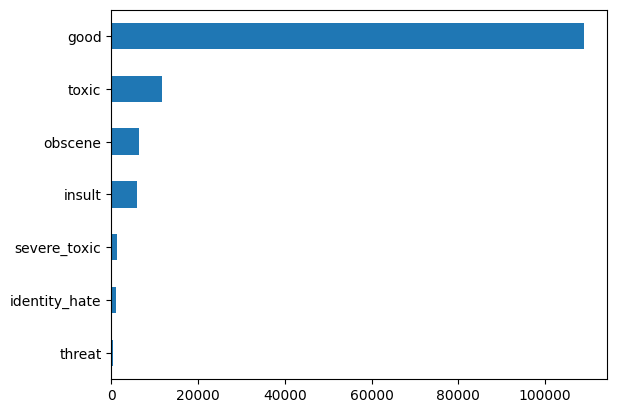

In [9]:
LABEL_COLUMNS = train_df.columns.tolist()[2:]
train_df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh")

<Axes: >

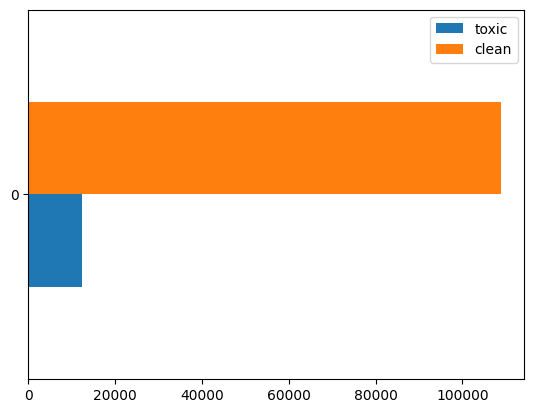

In [10]:
train_toxic = train_df[train_df['good'] == 0]
train_clean = train_df[train_df['good'] == 1]

pd.DataFrame(dict(toxic=[len(train_toxic)], clean=[len(train_clean)])).plot(kind='barh')

In [11]:
train_df = pd.concat([train_toxic, train_clean.sample(15_000)])

<Axes: >

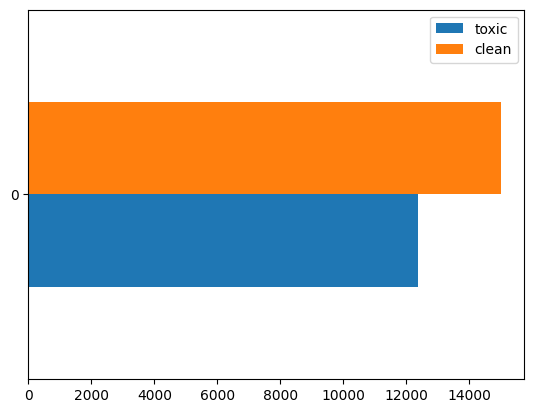

In [12]:
train_toxic = train_df[train_df['good'] == 0]
train_clean = train_df[train_df['good'] == 1]

pd.DataFrame(dict(toxic=[len(train_toxic)], clean=[len(train_clean)])).plot(kind='barh')

In [13]:
train_df.shape, val_df.shape, test_df.shape

((27384, 9), (6383, 9), (31915, 9))

In [14]:
# Train data
train_sentences = train_df['comment_text'].values
cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'good']
train_labels = train_df[cols].values

In [15]:
# Val data
val_sentences = val_df['comment_text'].values
cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'good']
val_labels = val_df[cols].values

In [16]:
# Test data
test_sentences = test_df['comment_text'].values
cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'good']
test_labels = test_df[cols].values

In [17]:
train_sentences, train_labels = np.array(train_sentences), np.array(train_labels)
val_sentences, val_labels = np.array(val_sentences), np.array(val_labels)
test_sentences, test_labels = np.array(test_sentences), np.array(test_labels)


print(train_sentences.shape, train_labels.shape)
print(val_sentences.shape, val_labels.shape)
print(test_sentences.shape, test_labels.shape)

(27384,) (27384, 7)
(6383,) (6383, 7)
(31915,) (31915, 7)


# Dataloader

In [18]:
class TC_Dataset(Dataset):

    def __init__(self, sequence, labels, tokenizer, max_length):
        self.tokenizer = tokenizer
        self.sequence = sequence
        self.labels = labels
        self.max_len = max_length

    def __len__(self):
        return len(self.sequence)

    def __getitem__(self, idx):

        sequence_in = self.sequence[idx]
        sequence_in = re.sub(r"\s+", " ", sequence_in).strip()

        inputs = self.tokenizer.encode_plus(
            sequence_in,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            pad_to_max_length=True,
            return_token_type_ids=True
        )

        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.labels[idx], dtype=torch.float)
        }

In [19]:
max_length = 200
train_batch_size = 8
val_batch_size = 8
test_batch_size = 8
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_dataset = TC_Dataset(train_sentences, train_labels, tokenizer, max_length)
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)

val_dataset = TC_Dataset(val_sentences, val_labels, tokenizer, max_length)
val_dataloader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=True)

test_dataset = TC_Dataset(test_sentences, test_labels, tokenizer, max_length)
test_dataloader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True)

# Model

In [20]:
class BERT_MLTC(nn.Module):
    def __init__(self, num_classes):
        super(BERT_MLTC, self).__init__()
      
        self.bert_model = BertModel.from_pretrained('bert-base-uncased')
        self.classifier = nn.Linear(self.bert_model.config.hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, ids, attention_mask, token_type_ids):
        
        output = self.bert_model(ids, attention_mask = attention_mask, token_type_ids = token_type_ids)
        output = self.classifier(output.pooler_output)
        output = self.sigmoid(output)

        return output

In [21]:
num_classes = 7

# Hyperparameters
epochs = 4
learning_rate = 1e-05


loss_function = nn.BCELoss()
model = BERT_MLTC(num_classes)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Model Training

In [22]:
def train_model(model, loss_function, optimizer, epochs, device):

    train_loss, val_loss = [], []
    total_time = 0
    min_average_loss = float('inf')

    for epoch in range(epochs):
        start_time = time.time()

        print("Epoch : ", epoch + 1)

        model.to(device)
        model.train()
        
        iterations = 0
        total_train_loss = 0
        y_true_train, y_pred_train = [], []
        for batch in tqdm(train_dataloader, desc = 'Training'):
            ids = batch['ids'].to(device, dtype = torch.long)
            mask = batch['mask'].to(device, dtype = torch.long)
            token_type_ids = batch['token_type_ids'].to(device, dtype = torch.long)
            targets = batch['targets'].to(device, dtype = torch.float)

            model.zero_grad()  
            pred_batch = model(ids, mask, token_type_ids)
            loss = loss_function(pred_batch, targets)
            total_train_loss += loss.item()

            y_true_train.extend(targets.cpu().detach().numpy().tolist())
            y_pred_train.extend(pred_batch.cpu().detach().numpy().tolist())

            loss.backward()
            optimizer.step()

            iterations += train_batch_size

            if iterations % 800 == 0:
                print('/tCurr Train loss : ', loss.item())

        model.eval()        
        total_val_loss = 0
        y_true_val, y_pred_val = [], []
        with torch.no_grad():
            for batch in tqdm(val_dataloader, desc='Evaluate'):
                ids = batch['ids'].to(device, dtype = torch.long)
                mask = batch['mask'].to(device, dtype = torch.long)
                token_type_ids = batch['token_type_ids'].to(device, dtype = torch.long)
                targets = batch['targets'].to(device, dtype = torch.float)

                pred_batch = model(ids, mask, token_type_ids)
                loss = loss_function(pred_batch, targets)
                total_val_loss += loss.item()

                y_true_val.extend(targets.cpu().detach().numpy().tolist())
                y_pred_val.extend(pred_batch.cpu().detach().numpy().tolist())


        y_true_train = np.array(y_true_train)
        y_pred_train = np.array(y_pred_train)
        y_true_val = np.array(y_true_val)
        y_pred_val = np.array(y_pred_val)

        y_pred_train = y_pred_train >= 0.5
        y_pred_val = y_pred_val >= 0.5

        train_f1_score_micro = metrics.f1_score(y_true_train, y_pred_train, average='micro')
        val_f1_score_micro = metrics.f1_score(y_true_val, y_pred_val, average='micro')

        average_train_loss = float(total_train_loss / len(train_dataloader))
        average_val_loss = float(total_val_loss / len(val_dataloader))

        print('Train F1 Score (Micro)', train_f1_score_micro)
        print('Val F1 Score (Micro)', val_f1_score_micro)
        print('Train loss', average_train_loss)
        print('Val loss', average_val_loss)

        train_loss.append(average_train_loss)
        val_loss.append(average_val_loss)

        if average_val_loss < min_average_loss:
            min_average_loss = average_val_loss
            torch.save(model, 'TC_model/model.pth')
            print("Best model saved")
            
        print("------------------------------------------------")

        end_time = time.time()
        epoch_time = end_time - start_time
        total_time += epoch_time

    avg_epoch_time = total_time / epochs
    return train_loss, val_loss, avg_epoch_time

In [23]:
train_loss, val_loss, avg_epoch_time = train_model(model, loss_function, optimizer, epochs, device)

Epoch :  1


Training:   3%|▎         | 101/3423 [00:32<15:20,  3.61it/s]

/tCurr Train loss :  0.3657100796699524


Training:   6%|▌         | 201/3423 [01:01<15:03,  3.57it/s]

/tCurr Train loss :  0.32269513607025146


Training:   9%|▉         | 301/3423 [01:32<15:02,  3.46it/s]

/tCurr Train loss :  0.23771187663078308


Training:  12%|█▏        | 401/3423 [02:01<14:02,  3.59it/s]

/tCurr Train loss :  0.33512985706329346


Training:  15%|█▍        | 501/3423 [02:30<13:50,  3.52it/s]

/tCurr Train loss :  0.14722466468811035


Training:  18%|█▊        | 601/3423 [03:00<13:19,  3.53it/s]

/tCurr Train loss :  0.18644796311855316


Training:  20%|██        | 701/3423 [03:30<12:38,  3.59it/s]

/tCurr Train loss :  0.12304308265447617


Training:  23%|██▎       | 801/3423 [03:59<12:17,  3.56it/s]

/tCurr Train loss :  0.21816003322601318


Training:  26%|██▋       | 901/3423 [04:28<11:49,  3.56it/s]

/tCurr Train loss :  0.18589302897453308


Training:  29%|██▉       | 1001/3423 [04:58<11:34,  3.49it/s]

/tCurr Train loss :  0.12940490245819092


Training:  32%|███▏      | 1101/3423 [05:28<11:05,  3.49it/s]

/tCurr Train loss :  0.27029892802238464


Training:  35%|███▌      | 1201/3423 [05:57<10:24,  3.56it/s]

/tCurr Train loss :  0.09119998663663864


Training:  38%|███▊      | 1301/3423 [06:27<09:59,  3.54it/s]

/tCurr Train loss :  0.17208267748355865


Training:  41%|████      | 1401/3423 [06:57<09:29,  3.55it/s]

/tCurr Train loss :  0.09616308659315109


Training:  44%|████▍     | 1501/3423 [07:26<08:56,  3.59it/s]

/tCurr Train loss :  0.12407985329627991


Training:  47%|████▋     | 1601/3423 [07:56<08:29,  3.57it/s]

/tCurr Train loss :  0.08808307349681854


Training:  50%|████▉     | 1701/3423 [08:25<08:07,  3.53it/s]

/tCurr Train loss :  0.15128377079963684


Training:  53%|█████▎    | 1801/3423 [08:55<07:40,  3.52it/s]

/tCurr Train loss :  0.17266908288002014


Training:  56%|█████▌    | 1901/3423 [09:24<07:17,  3.48it/s]

/tCurr Train loss :  0.09998415410518646


Training:  58%|█████▊    | 2001/3423 [09:54<06:45,  3.50it/s]

/tCurr Train loss :  0.4242549240589142


Training:  61%|██████▏   | 2101/3423 [10:24<06:22,  3.45it/s]

/tCurr Train loss :  0.22106677293777466


Training:  64%|██████▍   | 2201/3423 [10:53<05:46,  3.53it/s]

/tCurr Train loss :  0.21467894315719604


Training:  67%|██████▋   | 2301/3423 [11:23<05:17,  3.53it/s]

/tCurr Train loss :  0.07074787467718124


Training:  70%|███████   | 2401/3423 [11:52<05:03,  3.37it/s]

/tCurr Train loss :  0.1451585739850998


Training:  73%|███████▎  | 2501/3423 [12:22<04:23,  3.50it/s]

/tCurr Train loss :  0.043506257236003876


Training:  76%|███████▌  | 2601/3423 [12:51<03:55,  3.49it/s]

/tCurr Train loss :  0.17337638139724731


Training:  79%|███████▉  | 2701/3423 [13:21<03:26,  3.49it/s]

/tCurr Train loss :  0.11458496004343033


Training:  82%|████████▏ | 2801/3423 [13:50<02:57,  3.51it/s]

/tCurr Train loss :  0.12316932529211044


Training:  85%|████████▍ | 2901/3423 [14:20<02:28,  3.52it/s]

/tCurr Train loss :  0.15174607932567596


Training:  88%|████████▊ | 3001/3423 [14:50<01:59,  3.53it/s]

/tCurr Train loss :  0.17360593378543854


Training:  91%|█████████ | 3101/3423 [15:19<01:32,  3.48it/s]

/tCurr Train loss :  0.08081426471471786


Training:  94%|█████████▎| 3201/3423 [15:49<01:03,  3.50it/s]

/tCurr Train loss :  0.16385503113269806


Training:  96%|█████████▋| 3301/3423 [16:19<00:35,  3.46it/s]

/tCurr Train loss :  0.21558977663516998


Training:  99%|█████████▉| 3401/3423 [16:48<00:06,  3.49it/s]

/tCurr Train loss :  0.11671676486730576


Evaluate: 100%|██████████| 798/798 [01:24<00:00,  9.41it/s]


Train F1 Score (Micro) 0.8390913451486343
Val F1 Score (Micro) 0.9300090535552615
Train loss 0.17575790354774695
Val loss 0.05602459154584279
Best model saved
------------------------------------------------
Epoch :  2


Training:   3%|▎         | 101/3423 [00:29<15:55,  3.48it/s]

/tCurr Train loss :  0.11849437654018402


Training:   6%|▌         | 201/3423 [00:59<15:19,  3.50it/s]

/tCurr Train loss :  0.1586155742406845


Training:   9%|▉         | 301/3423 [01:29<14:56,  3.48it/s]

/tCurr Train loss :  0.16734066605567932


Training:  12%|█▏        | 401/3423 [01:58<14:15,  3.53it/s]

/tCurr Train loss :  0.2559947967529297


Training:  15%|█▍        | 501/3423 [02:28<13:58,  3.48it/s]

/tCurr Train loss :  0.09885291755199432


Training:  18%|█▊        | 601/3423 [02:58<13:32,  3.47it/s]

/tCurr Train loss :  0.057933259755373


Training:  20%|██        | 701/3423 [03:27<12:57,  3.50it/s]

/tCurr Train loss :  0.06791972368955612


Training:  23%|██▎       | 801/3423 [03:57<12:37,  3.46it/s]

/tCurr Train loss :  0.16770653426647186


Training:  26%|██▋       | 901/3423 [04:26<12:05,  3.48it/s]

/tCurr Train loss :  0.054656416177749634


Training:  29%|██▉       | 1001/3423 [04:56<11:26,  3.53it/s]

/tCurr Train loss :  0.10857584327459335


Training:  32%|███▏      | 1101/3423 [05:25<11:14,  3.44it/s]

/tCurr Train loss :  0.1648131161928177


Training:  35%|███▌      | 1201/3423 [05:55<10:37,  3.49it/s]

/tCurr Train loss :  0.08118416368961334


Training:  38%|███▊      | 1301/3423 [06:25<10:08,  3.49it/s]

/tCurr Train loss :  0.01254377793520689


Training:  41%|████      | 1401/3423 [06:55<09:46,  3.45it/s]

/tCurr Train loss :  0.32729968428611755


Training:  44%|████▍     | 1501/3423 [07:24<09:12,  3.48it/s]

/tCurr Train loss :  0.21796168386936188


Training:  47%|████▋     | 1601/3423 [07:54<08:37,  3.52it/s]

/tCurr Train loss :  0.059956688433885574


Training:  50%|████▉     | 1701/3423 [08:23<08:21,  3.44it/s]

/tCurr Train loss :  0.17460022866725922


Training:  53%|█████▎    | 1801/3423 [08:53<07:46,  3.48it/s]

/tCurr Train loss :  0.240629643201828


Training:  56%|█████▌    | 1901/3423 [09:22<07:18,  3.47it/s]

/tCurr Train loss :  0.22166359424591064


Training:  58%|█████▊    | 2001/3423 [09:52<06:44,  3.51it/s]

/tCurr Train loss :  0.22702600061893463


Training:  61%|██████▏   | 2101/3423 [10:22<06:19,  3.48it/s]

/tCurr Train loss :  0.22900979220867157


Training:  64%|██████▍   | 2201/3423 [10:51<05:49,  3.50it/s]

/tCurr Train loss :  0.16606664657592773


Training:  67%|██████▋   | 2301/3423 [11:21<05:20,  3.50it/s]

/tCurr Train loss :  0.19296585023403168


Training:  70%|███████   | 2401/3423 [11:51<04:51,  3.50it/s]

/tCurr Train loss :  0.1256646364927292


Training:  73%|███████▎  | 2501/3423 [12:20<04:22,  3.51it/s]

/tCurr Train loss :  0.13000847399234772


Training:  76%|███████▌  | 2601/3423 [12:50<04:00,  3.42it/s]

/tCurr Train loss :  0.06279774010181427


Training:  79%|███████▉  | 2701/3423 [13:20<03:26,  3.50it/s]

/tCurr Train loss :  0.05919526889920235


Training:  82%|████████▏ | 2801/3423 [13:49<02:57,  3.50it/s]

/tCurr Train loss :  0.1175575852394104


Training:  85%|████████▍ | 2901/3423 [14:19<02:27,  3.53it/s]

/tCurr Train loss :  0.08632472157478333


Training:  88%|████████▊ | 3001/3423 [14:48<01:59,  3.52it/s]

/tCurr Train loss :  0.10598600655794144


Training:  91%|█████████ | 3101/3423 [15:18<01:31,  3.53it/s]

/tCurr Train loss :  0.21717555820941925


Training:  94%|█████████▎| 3201/3423 [15:47<01:02,  3.55it/s]

/tCurr Train loss :  0.06069735437631607


Training:  96%|█████████▋| 3301/3423 [16:17<00:34,  3.55it/s]

/tCurr Train loss :  0.12237431108951569


Training:  99%|█████████▉| 3401/3423 [16:46<00:06,  3.56it/s]

/tCurr Train loss :  0.13821253180503845


Evaluate: 100%|██████████| 798/798 [01:24<00:00,  9.42it/s]


Train F1 Score (Micro) 0.8860199456029012
Val F1 Score (Micro) 0.918516437201461
Train loss 0.12161038913841601
Val loss 0.06228033534950229
------------------------------------------------
Epoch :  3


Training:   3%|▎         | 101/3423 [00:29<15:40,  3.53it/s]

/tCurr Train loss :  0.1412668526172638


Training:   6%|▌         | 201/3423 [00:59<15:16,  3.52it/s]

/tCurr Train loss :  0.0626627579331398


Training:   9%|▉         | 301/3423 [01:29<14:41,  3.54it/s]

/tCurr Train loss :  0.040215663611888885


Training:  12%|█▏        | 401/3423 [01:58<14:19,  3.52it/s]

/tCurr Train loss :  0.0418093279004097


Training:  15%|█▍        | 501/3423 [02:28<13:47,  3.53it/s]

/tCurr Train loss :  0.13216418027877808


Training:  18%|█▊        | 601/3423 [02:58<13:15,  3.55it/s]

/tCurr Train loss :  0.05020340159535408


Training:  20%|██        | 701/3423 [03:27<12:43,  3.56it/s]

/tCurr Train loss :  0.042957108467817307


Training:  23%|██▎       | 801/3423 [03:57<12:19,  3.55it/s]

/tCurr Train loss :  0.13374978303909302


Training:  26%|██▋       | 901/3423 [04:27<11:45,  3.57it/s]

/tCurr Train loss :  0.1296387016773224


Training:  29%|██▉       | 1001/3423 [04:56<11:18,  3.57it/s]

/tCurr Train loss :  0.052344027906656265


Training:  32%|███▏      | 1101/3423 [05:26<10:58,  3.53it/s]

/tCurr Train loss :  0.07559935748577118


Training:  35%|███▌      | 1201/3423 [05:55<10:26,  3.54it/s]

/tCurr Train loss :  0.21783530712127686


Training:  38%|███▊      | 1301/3423 [06:25<09:57,  3.55it/s]

/tCurr Train loss :  0.06016717478632927


Training:  41%|████      | 1401/3423 [06:55<09:36,  3.50it/s]

/tCurr Train loss :  0.05907810106873512


Training:  44%|████▍     | 1501/3423 [07:24<09:03,  3.54it/s]

/tCurr Train loss :  0.285417765378952


Training:  47%|████▋     | 1601/3423 [07:54<08:45,  3.47it/s]

/tCurr Train loss :  0.027852382510900497


Training:  50%|████▉     | 1701/3423 [08:24<08:07,  3.53it/s]

/tCurr Train loss :  0.13256004452705383


Training:  53%|█████▎    | 1801/3423 [08:54<07:40,  3.53it/s]

/tCurr Train loss :  0.0931948721408844


Training:  56%|█████▌    | 1901/3423 [09:23<07:12,  3.52it/s]

/tCurr Train loss :  0.23528291285037994


Training:  58%|█████▊    | 2001/3423 [09:53<06:42,  3.53it/s]

/tCurr Train loss :  0.03504320979118347


Training:  61%|██████▏   | 2101/3423 [10:23<06:13,  3.54it/s]

/tCurr Train loss :  0.05703173205256462


Training:  64%|██████▍   | 2201/3423 [10:52<05:48,  3.51it/s]

/tCurr Train loss :  0.03691481053829193


Training:  67%|██████▋   | 2301/3423 [11:22<05:17,  3.53it/s]

/tCurr Train loss :  0.12234167009592056


Training:  70%|███████   | 2401/3423 [11:52<04:46,  3.57it/s]

/tCurr Train loss :  0.11872309446334839


Training:  73%|███████▎  | 2501/3423 [12:21<04:24,  3.49it/s]

/tCurr Train loss :  0.12885929644107819


Training:  76%|███████▌  | 2601/3423 [12:51<03:53,  3.52it/s]

/tCurr Train loss :  0.10534048825502396


Training:  79%|███████▉  | 2701/3423 [13:20<03:23,  3.55it/s]

/tCurr Train loss :  0.09211688488721848


Training:  82%|████████▏ | 2801/3423 [13:50<02:55,  3.55it/s]

/tCurr Train loss :  0.12642693519592285


Training:  85%|████████▍ | 2901/3423 [14:19<02:26,  3.57it/s]

/tCurr Train loss :  0.1603817343711853


Training:  88%|████████▊ | 3001/3423 [14:49<01:58,  3.55it/s]

/tCurr Train loss :  0.07922753691673279


Training:  91%|█████████ | 3101/3423 [15:18<01:30,  3.55it/s]

/tCurr Train loss :  0.21520929038524628


Training:  94%|█████████▎| 3201/3423 [15:48<01:02,  3.56it/s]

/tCurr Train loss :  0.07219558209180832


Training:  96%|█████████▋| 3301/3423 [16:17<00:34,  3.58it/s]

/tCurr Train loss :  0.01540954876691103


Training:  99%|█████████▉| 3401/3423 [16:46<00:06,  3.61it/s]

/tCurr Train loss :  0.16359026730060577


Evaluate: 100%|██████████| 798/798 [01:24<00:00,  9.48it/s]


Train F1 Score (Micro) 0.9103196610128801
Val F1 Score (Micro) 0.9140592407175636
Train loss 0.09716127849021546
Val loss 0.06748370030593771
------------------------------------------------
Epoch :  4


Training:   3%|▎         | 101/3423 [00:29<15:52,  3.49it/s]

/tCurr Train loss :  0.030367618426680565


Training:   6%|▌         | 201/3423 [00:58<15:02,  3.57it/s]

/tCurr Train loss :  0.05410157889127731


Training:   9%|▉         | 301/3423 [01:28<14:57,  3.48it/s]

/tCurr Train loss :  0.08027716726064682


Training:  12%|█▏        | 401/3423 [01:57<14:21,  3.51it/s]

/tCurr Train loss :  0.048263903707265854


Training:  15%|█▍        | 501/3423 [02:27<13:55,  3.50it/s]

/tCurr Train loss :  0.05484640970826149


Training:  18%|█▊        | 601/3423 [02:56<13:35,  3.46it/s]

/tCurr Train loss :  0.17634738981723785


Training:  20%|██        | 701/3423 [03:25<12:39,  3.58it/s]

/tCurr Train loss :  0.09101064503192902


Training:  23%|██▎       | 801/3423 [03:55<12:17,  3.56it/s]

/tCurr Train loss :  0.18499881029129028


Training:  26%|██▋       | 901/3423 [04:24<11:46,  3.57it/s]

/tCurr Train loss :  0.06833264231681824


Training:  29%|██▉       | 1001/3423 [04:53<11:18,  3.57it/s]

/tCurr Train loss :  0.026416966691613197


Training:  32%|███▏      | 1101/3423 [05:23<10:47,  3.59it/s]

/tCurr Train loss :  0.005909310188144445


Training:  35%|███▌      | 1201/3423 [05:52<10:22,  3.57it/s]

/tCurr Train loss :  0.04390617087483406


Training:  38%|███▊      | 1301/3423 [06:21<09:54,  3.57it/s]

/tCurr Train loss :  0.06847318261861801


Training:  41%|████      | 1401/3423 [06:51<09:32,  3.53it/s]

/tCurr Train loss :  0.15139690041542053


Training:  44%|████▍     | 1501/3423 [07:21<09:04,  3.53it/s]

/tCurr Train loss :  0.14267359673976898


Training:  47%|████▋     | 1601/3423 [07:50<08:36,  3.52it/s]

/tCurr Train loss :  0.025286532938480377


Training:  50%|████▉     | 1701/3423 [08:20<08:06,  3.54it/s]

/tCurr Train loss :  0.0815233588218689


Training:  53%|█████▎    | 1801/3423 [08:50<07:34,  3.57it/s]

/tCurr Train loss :  0.10559411346912384


Training:  56%|█████▌    | 1901/3423 [09:19<07:27,  3.40it/s]

/tCurr Train loss :  0.19668903946876526


Training:  58%|█████▊    | 2001/3423 [09:49<06:39,  3.56it/s]

/tCurr Train loss :  0.1129102110862732


Training:  61%|██████▏   | 2101/3423 [10:19<06:15,  3.52it/s]

/tCurr Train loss :  0.1232055276632309


Training:  64%|██████▍   | 2201/3423 [10:48<05:42,  3.57it/s]

/tCurr Train loss :  0.07200336456298828


Training:  67%|██████▋   | 2301/3423 [11:18<05:16,  3.54it/s]

/tCurr Train loss :  0.051867447793483734


Training:  70%|███████   | 2401/3423 [11:47<04:49,  3.53it/s]

/tCurr Train loss :  0.1279144287109375


Training:  73%|███████▎  | 2501/3423 [12:17<04:24,  3.49it/s]

/tCurr Train loss :  0.027753040194511414


Training:  76%|███████▌  | 2601/3423 [12:47<03:55,  3.49it/s]

/tCurr Train loss :  0.02195594646036625


Training:  79%|███████▉  | 2701/3423 [13:16<03:24,  3.53it/s]

/tCurr Train loss :  0.10853581130504608


Training:  82%|████████▏ | 2801/3423 [13:46<02:56,  3.52it/s]

/tCurr Train loss :  0.07679222524166107


Training:  85%|████████▍ | 2901/3423 [14:16<02:31,  3.45it/s]

/tCurr Train loss :  0.024342112243175507


Training:  88%|████████▊ | 3001/3423 [14:45<01:58,  3.57it/s]

/tCurr Train loss :  0.039973337203264236


Training:  91%|█████████ | 3101/3423 [15:15<01:35,  3.38it/s]

/tCurr Train loss :  0.06174074858427048


Training:  94%|█████████▎| 3201/3423 [15:44<01:02,  3.54it/s]

/tCurr Train loss :  0.123838409781456


Training:  96%|█████████▋| 3301/3423 [16:14<00:34,  3.55it/s]

/tCurr Train loss :  0.10829628258943558


Training:  99%|█████████▉| 3401/3423 [16:44<00:06,  3.53it/s]

/tCurr Train loss :  0.037359338253736496


Evaluate: 100%|██████████| 798/798 [01:25<00:00,  9.35it/s]


Train F1 Score (Micro) 0.9257944617738099
Val F1 Score (Micro) 0.8933813348103018
Train loss 0.0812422954677347
Val loss 0.09327143251863518
------------------------------------------------


# Evaluation

In [24]:
def test_scores(model, device):

    model.eval()

    y_true = []
    y_pred = []
    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc='Evaluate'):
            ids = batch['ids'].to(device, dtype = torch.long)
            mask = batch['mask'].to(device, dtype = torch.long)
            token_type_ids = batch['token_type_ids'].to(device, dtype = torch.long)
            targets = batch['targets'].to(device, dtype = torch.float)

            pred_batch = model(ids, mask, token_type_ids)

            y_true.extend(targets.cpu().detach().numpy().tolist())
            y_pred.extend(pred_batch.cpu().detach().numpy().tolist())


    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    y_pred = y_pred >= 0.5

    accuracy = metrics.accuracy_score(y_true, y_pred)
    f1_score_micro = metrics.f1_score(y_true, y_pred, average='micro')

    print('Test Accuracy', accuracy)
    print('Test F1 Score (Micro)', f1_score_micro)

    print('Classification report')
    print(classification_report(y_true, y_pred, zero_division=0, target_names=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult','identity_hate', 'good']))

In [25]:
model = torch.load('TC_model/model.pth')
test_scores(model, device)

Evaluate: 100%|██████████| 3990/3990 [07:01<00:00,  9.46it/s]


Test Accuracy 0.9055303148989503
Test F1 Score (Micro) 0.9309283133461739
Classification report
               precision    recall  f1-score   support

        toxic       0.70      0.92      0.80      3002
 severe_toxic       0.48      0.47      0.48       297
      obscene       0.81      0.85      0.83      1612
       threat       0.00      0.00      0.00        91
       insult       0.72      0.79      0.75      1495
identity_hate       0.52      0.57      0.55       277
         good       0.99      0.96      0.97     28733

    micro avg       0.93      0.93      0.93     35507
    macro avg       0.60      0.65      0.62     35507
 weighted avg       0.94      0.93      0.93     35507
  samples avg       0.94      0.94      0.94     35507



In [26]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad) 

print(model)
print(f'The model has {num_params:,} trainable parameters')

BERT_MLTC(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

In [27]:
print('Train loss', train_loss)
print('Val loss', val_loss)

Train loss [0.17575790354774695, 0.12161038913841601, 0.09716127849021546, 0.0812422954677347]
Val loss [0.05602459154584279, 0.06228033534950229, 0.06748370030593771, 0.09327143251863518]


In [28]:
print('Avg epoch time', round(avg_epoch_time, 2), 'secs')

Avg epoch time 1099.83 secs
